In [46]:
import warnings
warnings.filterwarnings("ignore")
import sys, os
sys.path.append(os.path.abspath("../.."))
from configs import GOOGLE_APPLICATION_CREDENTIALS,GCS_BUCKET_NAME,GCS_PROJECT_ID
from google.cloud import bigquery
from src.utils.io_utils import upload_to_bigquery

In [47]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [48]:
client = bigquery.Client.from_service_account_json(GOOGLE_APPLICATION_CREDENTIALS)

In [86]:
query = """SELECT *
FROM `khangtestdbt.xecupredict.data_train_model` """
data = client.query(query).to_dataframe()
data.head(1)

,km,age,km_per_year,log_age,origin_Nhập Khẩu,origin_Trong Nước,body_Convertible,body_Coupe,body_Hatchback,body_Kiểu Dáng Khác,...,is_imported_True,imported_age_False_Mid,imported_age_False_New,imported_age_False_Old,imported_age_False_Young,imported_age_True_Mid,imported_age_True_New,imported_age_True_Old,imported_age_True_Young,price
0,-1.376184,1.293177,-1.791607,1.19871,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205000000.0


In [87]:
df = data.copy()

In [88]:
df.shape

(11305, 82)

In [89]:
X = df.drop(columns=["price"])
y = np.log1p(df["price"])

In [90]:
np.random.seed(42)

X_train, X_test, y_train, y_test =  train_test_split(X,
                                                     y,
                                                     test_size=0.2)

In [91]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),

    "Random Forest": RandomForestRegressor(),

    "Gradient Boosting": GradientBoostingRegressor(),
}

rows = []  

for name, model in models.items():
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred  = model.predict(X_test)

    r2_train = r2_score(y_train, train_pred)
    r2_test  = r2_score(y_test, test_pred)

    rmse_train = root_mean_squared_error(y_train, train_pred)
    rmse_test  = root_mean_squared_error(y_test, test_pred)

    rows.append([name, r2_train, r2_test, rmse_train, rmse_test])

df_results = pd.DataFrame(
    rows,
    columns=["Model", "R2_Train", "R2_Test", "RMSE_Train", "RMSE_Test"]
)

df_results


,Model,R2_Train,R2_Test,RMSE_Train,RMSE_Test
0,Linear Regression,0.774789,0.760374,0.397131,0.407649
1,Ridge Regression,0.774714,0.760525,0.397196,0.407521
2,Random Forest,0.980005,0.835263,0.118330,0.337998
3,Gradient Boosting,0.817556,0.797793,0.357440,0.374471


In [85]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3, 5]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=rf_param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

y_tr_pred = rf_best.predict(X_train)
y_te_pred = rf_best.predict(X_test)

print("==== RANDOM FOREST ====")
print("Best params:", rf_grid.best_params_)
print("R2 Train:", r2_score(y_train, y_tr_pred))
print("R2 Test :", r2_score(y_test, y_te_pred))
print("RMSE Train:", np.sqrt(mean_squared_error(y_train, y_tr_pred)))
print("RMSE Test :", np.sqrt(mean_squared_error(y_test, y_te_pred)))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


KeyboardInterrupt: 

In [32]:
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}

gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid=gb_param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train, y_train)
gb_best = gb_grid.best_estimator_

y_tr_pred = gb_best.predict(X_train)
y_te_pred = gb_best.predict(X_test)

print("==== GRADIENT BOOSTING ====")
print("Best params:", gb_grid.best_params_)
print("R2 Train:", r2_score(y_train, y_tr_pred))
print("R2 Test :", r2_score(y_test, y_te_pred))
print("RMSE Train:", np.sqrt(mean_squared_error(y_train, y_tr_pred)))
print("RMSE Test :", np.sqrt(mean_squared_error(y_test, y_te_pred)))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
==== GRADIENT BOOSTING ====
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
R2 Train: 0.9138857310879235
R2 Test : 0.8352728684303141
RMSE Train: 0.24557050324098656
RMSE Test : 0.33798874242227883


In [38]:
round(np.exp(0.337)-1,2)

np.float64(0.4)

In [39]:
round(np.exp(0.245)-1,2)

np.float64(0.28)

In [40]:
import joblib

joblib.dump(gb_best, "../../model/gradient_boosting_best.joblib")

['../../model/gradient_boosting_best.joblib']

In [41]:
from joblib import load

ohe = load("../../model/onehot_encoder.pkl")
scaler = load("../../model/scaler.pkl")

In [43]:
num_cols = ["km", "age", "km_per_year", "log_age"]

cat_features = ohe.get_feature_names_out()
feature_names = np.concatenate([num_cols, cat_features])

len(feature_names), len(rf_best.feature_importances_)


(89, 89)

In [44]:
cat_cols = list(ohe.feature_names_in_)

num_features = num_cols 
cat_features = ohe.get_feature_names_out(cat_cols)

feature_names = np.concatenate([num_features, cat_features])



In [45]:
importance_df_rf = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_best.feature_importances_
}).sort_values("importance", ascending=False)

importance_df_rf.head(10)


,feature,importance
1,age,0.200852
3,log_age,0.184369
54,brand_tier_Luxury,0.144161
44,brand_Porsche,0.051597
34,brand_Land Rover,0.043880
2,km_per_year,0.037609
0,km,0.036239
25,brand_Bmw,0.035264
35,brand_Lexus,0.022555
8,body_Hatchback,0.021576


In [15]:
round(importance_df_rf["importance"].sum() * 100, 2)

np.float64(100.0)

In [16]:
importance_df_gb = pd.DataFrame({
    "feature": feature_names,
    "importance": gb_best.feature_importances_
}).sort_values("importance", ascending=False)
importance_df_gb.head(10)

,feature,importance
1,age,0.323910
34,brand_mercedes-benz,0.096936
32,brand_lexus,0.086782
0,km,0.075146
41,brand_porsche,0.065047
23,brand_bmw,0.046695
6,body_hatchback,0.043732
31,brand_land rover,0.039049
39,brand_other,0.034289
14,body_suv,0.022883


In [17]:
round(importance_df_gb["importance"].sum() * 100, 2)

np.float64(100.0)

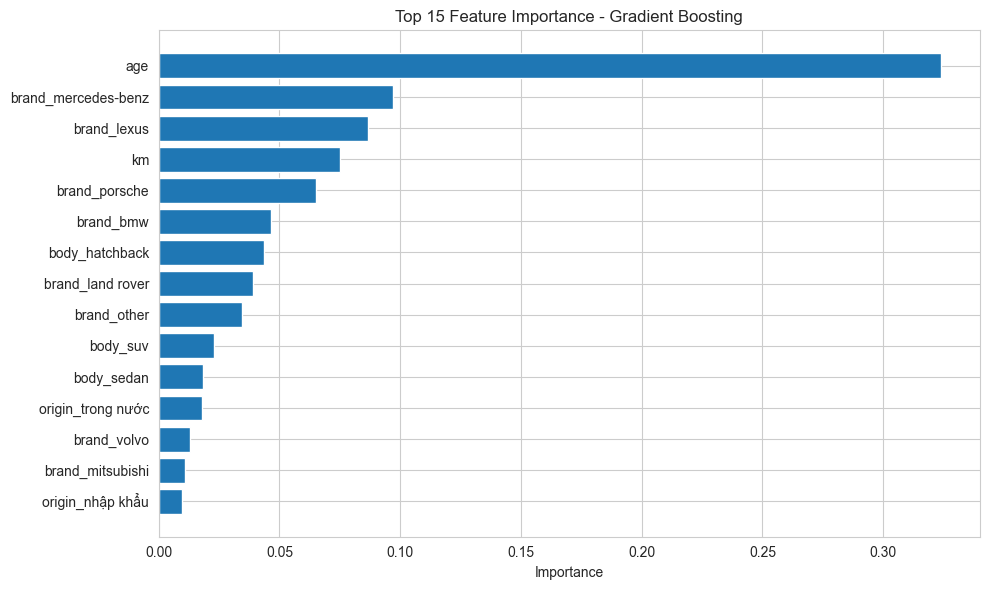

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(10,6))
plt.barh(
    importance_df_gb.head(15)["feature"][::-1],
    importance_df_gb.head(15)["importance"][::-1]
)
plt.title("Top 15 Feature Importance - Gradient Boosting")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


* save model

In [19]:
import joblib

joblib.dump(gb_best, "../../model/gradient_boosting_best.joblib")


['../../model/gradient_boosting_best.joblib']

In [20]:
# end